# Stable Diffusion -> SVG


## reference:
Simple SD -> SVG Iterative opt(https://www.kaggle.com/code/jiazhuang/new-metric-simple-sd-svg-iterative-optimize)

### このnotebookは、**テキストによる説明文から画像を生成し、その画像をSVG（Scalable Vector Graphics）形式に変換する一連のプロセスを実装し、評価するもの**です。主な目的は、コンペティションの評価指標（特に美的スコアとOCRスコアの積）を最大化するようなSVG画像を生成することです。

以下に、ノートブックの主要な処理の流れを説明します。

### 1. 初期設定とライブラリのインポート
- 必要なライブラリ（PyTorch、Diffusers、Transformers、OpenCV、Pillowなど）をインポートします。
- `CFG`クラスで、モデルのパス、画像生成パラメータ、SVG変換パラメータ、評価用パラメータなど、ノートブック全体で使用する設定値を一元管理しています。
- Kaggle Hubから、SVG画像の忠実度を評価するための`metric`パッケージをインポートします。https://www.kaggle.com/code/jiazhuang/new-metric-simple-sd-svg-iterative-optimize

### 2. 評価メトリックヘルパー関数の定義
- コンペティションで用いられる評価指標（VQAスコア、美的スコア、OCRスコア、およびそれらを統合したコンペティションスコア）を計算するための関数群を定義します。
- `bitmap_score_instance_impl`と`bitmap_score_instance`は、主にビットマップ画像（またはSVGから変換されたPNG画像）と質問応答データに基づいてスコアを算出します。

### 3. Stable Diffusionモデルのロード
- テキストプロンプトから画像を生成するために、Stable Diffusionモデル（ここでは`stabilityai/stable-diffusion-v2`）をKaggle Hub経由でロードします。
- 高速化とメモリ効率向上のため、最適化されたスケジューラ（`DDIMScheduler`）を使用し、モデルを半精度浮動小数点数（`torch.float16`）でロードします。また、不要なセーフティチェッカーは無効化しています。
- モデルを適切なデバイス（GPUが利用可能であればGPU、そうでなければCPU）に配置します。

### 4. 学習データのロードと前処理
- コンペティションで提供される学習データ（`train.csv`：画像の説明文など）と質問データ（`questions.parquet`）をロードします。
- 質問データは、各画像IDに対応する質問、選択肢、回答のセットとして整形され、学習データフレームと結合されます。これにより、各説明文に対して評価用の質問応答データが紐づけられます。

### 5. ビットマップ画像の生成 (`generate_bitmap`関数)
- `generate_bitmap`関数は、与えられたテキストプロンプト（説明文）、ネガティブプロンプト、推論ステップ数、ガイダンススケールに基づいて、Stable Diffusionモデルを用いてビットマップ画像を生成します。
- デモンストレーションとして、学習データから一つの説明文を取り出し、プロンプトを組み立てて実際に画像を生成し、そのスコアを計算しています。

### 6. ビットマップ画像からSVGへの変換 (`bitmap_to_svg_layered`関数など)
この部分がノートブックの核心の一つで、ビットマップ画像をSVGに変換する複雑な処理を行います。
- **`compress_hex_color`**: SVGで使われる16進数カラーコードを短縮表現に変換し、ファイルサイズを削減します。
- **`extract_features_by_scale`**:
    - 画像の色を量子化（k-means法）して主要な色を抽出します。
    - 各色領域の輪郭を検出し、`cv2.approxPolyDP`でポリゴンに近似（単純化）します。
    - ポリゴンを面積、画像中心からの距離、複雑さなどに基づいて「重要度」でソートし、階層的な特徴リストを作成します。
- **`simplify_polygon`**: ポリゴンの頂点座標の精度を落としたり、頂点数を間引いたりして、SVGのファイルサイズをさらに削減します。
- **`bitmap_to_svg_layered`**:
    - 画像サイズに応じて量子化する色数を適応的に決定します。
    - 必要に応じて画像をリサイズします。
    - `extract_features_by_scale`で得られたポリゴン特徴を、SVGのファイルサイズ制限 (`svg_max_size_bytes`) を超えないように、かつ効率的にスペースを埋めるように（`svg_adaptive_fill`がTrueの場合）、SVG要素（`<polygon>`）として組み立てます。
    - `adaptive_fill`が有効な場合、ポリゴンの単純化レベル（`simplify_polygon`を使用）を調整しながら、より多くの特徴をSVGに含めようとします。

### 7. スコアベースの最適化と`Model`クラスの実装
- **`get_aes_and_ocr_score`**: SVGコンテンツを受け取り、それをPNG画像に変換後、美的スコアとOCRスコアを計算します。
- **`Model`クラス**:
    - このクラスは、画像生成からSVG変換、そしてスコア最適化までの一連の処理をカプセル化します。
    - `__init__`: プロンプトの接頭辞・接尾辞、Stable Diffusionの推論ステップ数・ガイダンススケール、最適化のための試行回数などを`CFG`から設定します。
    - `gen_bitmap`: `Model`クラス固有のパラメータ設定でビットマップ画像を生成します。
    - `predict_impl`:
        1. 説明文からビットマップ画像を生成 (`gen_bitmap`)。
        2. 生成したビットマップをSVGに変換 (`bitmap_to_svg_layered`)。
        3. SVGの美的スコアとOCRスコアを取得 (`get_aes_and_ocr_score`)。
        4. 美的スコアとOCRスコアの**積**を最終スコアとして計算。
        5. 上記1～4を`model_num_attempt`回繰り返し、最終スコアが最も高かったSVGとその元ビットマップを返します。
    - `predict`: `predict_impl`を呼び出し、最終的に最適と判断されたSVG文字列のみを返します。

### 8. 学習データセット全体での評価と結果の可視化
- 作成した`Model`クラスのインスタンスを使って、学習データセットの各説明文に対して`predict_impl`を実行し、最適なSVGと対応するビットマップ画像を取得します。
- 生成された各ビットマップ画像とSVG画像について、コンペティションの評価指標（`bitmap_score_instance`や`metric.score_instance`を使用）を計算します。
- 学習データセットの各サンプルについて、元のビットマップ画像と生成されたSVG画像を並べて表示し、それぞれのスコア（総合スコア、VQA、OCR、美的スコア）を比較できるように可視化します。
- 最後に、学習データセット全体でのビットマップスコアの平均とSVGスコアの平均を算出し、このアプローチの全体的な性能を評価します。これは、コンペティションのリーダーボード（LB）でのスコアを予測する試みでもあります。

### まとめ
このノートブックは、Stable Diffusionによる画像生成と、高度な画像処理技術（色量子化、輪郭抽出、ポリゴン近似、適応的単純化）を組み合わせたSVG変換、そして評価指標に基づく最適化を行うことで、高品質なSVG画像を生成することを目指しています。特に、ファイルサイズ制限のある中で、視覚的な品質（美的スコア）と内容の認識可能性（OCRスコア）のバランスを取ろうとしている点が特徴的です。

In [1]:
#| default_exp core

In [2]:
#| export
# 必要なライブラリをインポート
import kagglehub

import os
import io
import re
import random
import base64
from io import BytesIO

import time
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from IPython.display import SVG # SVG表示用

from PIL import Image # 画像処理用
import cv2 # OpenCV 画像処理用

from diffusers import StableDiffusionPipeline, DDIMScheduler # Stable Diffusionモデル用
from transformers import AutoProcessor, AutoModel # Hugging Face Transformersモデル用

# Kaggle HubからSVG画像忠実度評価用のメトリックパッケージをインポート
metric = kagglehub.package_import('jiazhuang/svg-image-fidelity')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Installing python dependencies for Package 'kagglehub_package_jiazhuang_svg_image_fidelity_12', logging progress to '/tmp/kagglehub-package-dependencies-install-eh0s_wf7.txt'.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
#| export
# 設定値を管理するクラス
class CFG:
    # デバイス設定
    _PREFERRED_DEVICE_IF_CUDA = "cuda:1"
    device = _PREFERRED_DEVICE_IF_CUDA if torch.cuda.is_available() else "cpu"

    # 一般設定
    random_seed = 42 # 乱数シード

    # Stable Diffusionモデル設定
    stable_diffusion_model_name = "stabilityai/stable-diffusion-v2/pytorch/1/1" # 使用するモデル名
    sd_torch_dtype = torch.float16 # Stable Diffusionのデータ型（メモリ削減と高速化のため半精度）
    sd_safety_checker = None  # セーフティチェッカーを無効化（速度向上のため）

    # ビットマップ生成パラメータ (generate_bitmap関数および一般用途)
    bitmap_prompt_prefix = "Simple, classic image of" # プロンプト接頭辞
    bitmap_prompt_suffix = "with flat color blocks, beautiful, minimal details, solid colors only" # プロンプト接尾辞
    bitmap_negative_prompt = "lines, framing, hatching, background, textures, patterns, details, outlines" # ネガティブプロンプト
    bitmap_num_inference_steps_default = 20  # generate_bitmapのデフォルト推論ステップ数
    bitmap_guidance_scale_default = 15       # generate_bitmapのデフォルトガイダンススケール

    # ビットマップからSVGへの変換パラメータ (bitmap_to_svg_layered関数用)
    svg_max_size_bytes = 10000 # SVGファイルの最大バイト数
    svg_resize = True # SVG変換前にリサイズするかどうか
    svg_target_size = (384, 384) # リサイズする場合のターゲットサイズ
    svg_adaptive_fill = True # SVG生成時に適応的に要素を配置・単純化してスペースを埋めるか
    svg_num_colors_default = None # 量子化する色の数。Noneの場合、bitmap_to_svg_layered内の適応ロジックを使用

    # bitmap_to_svg_layered内の適応的な色数ロジック用パラメータ
    svg_num_colors_small_image_threshold = 65536  # 例: 256x256ピクセル
    svg_num_colors_medium_image_threshold = 262144 # 例: 512x512ピクセル
    svg_num_colors_for_small_image = 8  # 小さい画像用の色数
    svg_num_colors_for_medium_image = 12 # 中程度の画像用の色数
    svg_num_colors_for_large_image = 16 # 大きい画像用の色数
    
    # extract_features_by_scale用パラメータ (bitmap_to_svg_layered内で使用)
    svg_contour_min_area = 20 # 輪郭抽出時の最小面積（これ以下の面積の輪郭は無視）
    svg_approx_poly_dp_epsilon_factor = 0.02 # 輪郭近似（単純化）の際のepsilon係数

    # AESおよびOCRスコア計算パラメータ (get_aes_and_ocr_score関数用)
    aes_ocr_seed = 33 # 美的スコア・OCRスコア計算時の乱数シード
    aes_ocr_jpeg_quality = 90 # JPEG圧縮品質

    # Modelクラスのパラメータ
    model_default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>""" # デフォルトSVG
    # これらはビットマップ生成パラメータと同じでも、モデル固有の調整に応じて異なっていても良い
    model_prompt_prefix = "Simple, classic image of"
    model_prompt_suffix = "with flat color blocks, beautiful, minimal details, solid colors only"
    model_negative_prompt = "lines, framing, hatching, background, textures, patterns, details, outlines"
    model_num_inference_steps = 25 # Modelクラス内での推論ステップ数
    model_guidance_scale = 20      # Modelクラス内でのガイダンススケール
    model_num_attempt = 3          # Modelクラス内での生成試行回数

## コンペティションメトリックヘルパー
コンペティションで使用される評価指標を計算するためのヘルパー関数群です。
主に画像（ビットマップやSVGから変換されたPNG）と質問応答データを用いて、
VQAスコア、美的スコア、OCRスコア、そしてそれらを統合した最終スコアを算出します。

SVGに変換する前に、元のビットマップのメトリックも評価したいと考えています。これを[metric package](https://www.kaggle.com/code/jiazhuang/svg-image-fidelity)を使用して実装しましょう。

In [4]:
import numpy as np # numpyは既にインポート済みだが、セル単位の自己完結性のため記述
import statistics # statisticsは既にインポート済みだが、セル単位の自己完結性のため記述
import pandas as pd # pandasは既にインポート済みだが、セル単位の自己完結性のため記述

# 指定されたサイズに画像をリサイズする関数
def image_resize(image, size=(384, 384)): # 注意: target_sizeは一貫性があればCFGからも取得可能
    return image.convert('RGB').resize(size)

# ビットマップ画像のスコア（インスタンス単位）を計算する内部実装関数
# VQAスコア、美的スコア、OCRスコア、およびそれらを統合したコンペティションスコアを返す
def bitmap_score_instance_impl(multiple_choice_qa, image, random_seed=CFG.random_seed): # CFG.random_seedを使用
    rng = np.random.RandomState(random_seed) # 指定されたシードで乱数生成器を初期化
    group_seed = rng.randint(0, np.iinfo(np.int32).max) # 評価用シードを生成
    
    # 画像処理（リサイズ）
    image_processor = metric.ImageProcessor(image=image_resize(image), seed=group_seed).apply()
    processed_image = image_processor.image.copy() # 処理済み画像を取得
    
    # QAデータ取得
    questions = multiple_choice_qa['question']
    choices = multiple_choice_qa['choices']
    answers = multiple_choice_qa['answer']
    
    # 各スコアの計算
    aesthetic_score = metric.aesthetic_evaluator.score(processed_image) # 美的スコア
    vqa_score = metric.vqa_evaluator.score(questions, choices, answers, processed_image) # VQAスコア
    
    # OCRスコア計算用の画像処理（ランダムクロップ・リサイズ、JPEG圧縮）
    image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=CFG.aes_ocr_jpeg_quality) # qualityはCFGから取得
    ocr_score = metric.vqa_evaluator.ocr(image_processor.image) # OCRスコア
    
    # 最終的なインスタンススコアの計算 (VQAと美的スコアの調和平均にOCRスコアを乗算)
    instance_score = metric.harmonic_mean(vqa_score, aesthetic_score, beta=0.3) * ocr_score
    
    return instance_score, vqa_score, ocr_score, aesthetic_score

# ビットマップ画像のスコアを計算する関数 (単一または複数の画像に対応)
def bitmap_score_instance(multiple_choice_qa, image, random_seed=CFG.random_seed): # CFG.random_seedを使用
    is_single = not isinstance(image, list) # 入力が単一画像かどうかを判定
    if is_single:
        # 単一画像の場合、リストに変換して統一的に処理
        multiple_choice_qa = [multiple_choice_qa]
        image = [image]

    assert len(multiple_choice_qa) == len(image), "QAデータと画像の数が一致しません"

    results = []
    score_df_rows = []
    for one_image, one_multiple_choice_qa in zip(image, multiple_choice_qa, strict=True):
        # 各画像に対してスコア計算
        instance_score, vqa_score, ocr_score, aesthetic_score = bitmap_score_instance_impl(
            one_multiple_choice_qa, one_image, random_seed=random_seed # random_seedを渡す
        )
        results.append(instance_score)
        score_df_rows.append([instance_score, vqa_score, ocr_score, aesthetic_score])

    fidelity = statistics.mean(results) if results else 0.0 # 平均スコアを計算
    score_df = pd.DataFrame(score_df_rows, columns=['competition_score', 'vqa_score', 'ocr_score', 'aesthetic_score'])
    
    if is_single:
        # 単一画像の場合は辞書形式でスコアを返す
        return score_df.iloc[0].to_dict()
    else:
        # 複数画像の場合は平均スコアと詳細スコアのDataFrameを返す
        return float(fidelity), score_df

## Stable Diffusionのロード
Stable DiffusionモデルをKaggle Hubからダウンロードし、パイプラインを初期化します。
高速化のため、最適化されたスケジューラを使用し、半精度浮動小数点数(float16)でモデルをロードします。
また、セーフティチェッカーは無効化します。

In [5]:
#| export

# GPUが使用されていることを確認 (CFGクラスで設定されたデバイスを使用)
print(f"使用デバイス: {CFG.device}")

# Stable DiffusionモデルのパスをKaggle Hubから取得
stable_diffusion_path = kagglehub.model_download(CFG.stable_diffusion_model_name)

# 最適化されたDDIMスケジューラをロード
scheduler = DDIMScheduler.from_pretrained(stable_diffusion_path, subfolder="scheduler")

# Stable Diffusionパイプラインをロード
# 半精度(torch_dtype)を使用し、セーフティチェッカーを無効化(safety_checker=None)して高速化
pipe = StableDiffusionPipeline.from_pretrained(
    stable_diffusion_path,
    scheduler=scheduler,
    torch_dtype=CFG.sd_torch_dtype,
    safety_checker=CFG.sd_safety_checker
)

# モデルをGPU (またはCPU) に移動
pipe.to(CFG.device)

使用デバイス: cuda:1


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "/kaggle/input/stable-diffusion-v2/pytorch/1/1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## データのロード
コンペティション用の学習データ（`train.csv`）と質問データ（`questions.parquet`）をロードします。
質問データは、各画像IDに対応する質問、選択肢、回答のセットが含まれるように整形されます。

In [6]:
import pandas as pd # pandasは既にインポート済みだが、セル単位の自己完結性のため記述
import json # jsonは既にインポート済みだが、セル単位の自己完結性のため記述

In [7]:
# コンペティションデータをKaggle Hubからダウンロード
# このパスは動的に決定されるため、ハイパーパラメータではない
drawing_with_llms_path = kagglehub.competition_download('drawing-with-llms')

# 学習データと質問データをロード
train_df = pd.read_csv(f'{drawing_with_llms_path}/train.csv')
train_question_df = pd.read_parquet(f'{drawing_with_llms_path}/questions.parquet')

In [8]:
# 質問データを画像IDごとにグループ化し、辞書形式に変換
train_question_df = train_question_df.groupby('id').apply(lambda df: df.to_dict(orient='list'))
train_question_df = train_question_df.reset_index(name='qa') # グループ化結果を新しいカラム 'qa' に格納

# 'qa' カラムから質問、選択肢、回答を抽出し、JSON文字列として格納
# ensure_ascii=False で日本語がエスケープされないようにする
train_question_df['question'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['question'], ensure_ascii=False))
train_question_df['choices'] = train_question_df.qa.apply(
    lambda qa: json.dumps([x.tolist() for x in qa['choices']], ensure_ascii=False) # 選択肢はnumpy配列の場合があるのでリストに変換
)
train_question_df['answer'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['answer'], ensure_ascii=False))

# 学習データフレームに整形した質問データをマージ
train_df = pd.merge(train_df, train_question_df, how='left', on='id')

# 評価メトリック関数が扱いやすいように、質問・選択肢・回答をまとめた辞書カラムを作成
train_df['multiple_choice_qa'] = train_df.apply(
    lambda r: {
        'question': json.loads(r.question),
        'choices': json.loads(r.choices),
        'answer': json.loads(r.answer)
    },
    axis=1,
)

# 最初の数行を表示してデータを確認
train_df.head()

<ipython-input-8-b937f655a122>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_question_df = train_question_df.groupby('id').apply(lambda df: df.to_dict(orient='list'))


id                                        description  \
0  02d892                            a purple forest at dusk   
1  0dcd2e              gray wool coat with a faux fur collar   
2  1e9ac1                 a lighthouse overlooking the ocean   
3  2b25db  burgundy corduroy pants with patch pockets and...   
4  4e6a54                           orange corduroy overalls   

                                                  qa  \
0  {'id': ['02d892', '02d892', '02d892', '02d892'...   
1  {'id': ['0dcd2e', '0dcd2e', '0dcd2e', '0dcd2e'...   
2  {'id': ['1e9ac1', '1e9ac1', '1e9ac1', '1e9ac1'...   
3  {'id': ['2b25db', '2b25db', '2b25db', '2b25db'...   
4  {'id': ['4e6a54', '4e6a54', '4e6a54', '4e6a54'...   

                                            question  \
0  ["What is the main setting of the image?", "Is...   
1  ["What color is the coat?", "What part of the ...   
2  ["Is there an ocean visible in the image?", "W...   
3  ["Are the pants yellow?", "Do the pants have p...   
4  ["What material is the item?", "Is a hat depic...   

                                             choices  \
0  [["beach", "desert", "forest", "mountain"], ["...   
1  [["blue", "brown", "gray", "red"], ["collar", ...   
2  [["no", "yes"], ["inside", "next to", "overloo...   
3  [["no", "yes"], ["no", "yes"], ["no", "yes"], ...   
4  [["corduroy", "denim", "leather", "silk"], ["n...   

                                  answer  \
0    ["forest", "yes", "dusk", "purple"]   
1       ["gray", "collar", "no", "wool"]   
2     ["yes", "overlooking", "no", "no"]   
3          ["no", "yes", "yes", "pants"]   
4  ["corduroy", "no", "yes", "overalls"]   

                                  multiple_choice_qa  
0  {'question': ['What is the main setting of the...  
1  {'question': ['What color is the coat?', 'What...  
2  {'question': ['Is there an ocean visible in th...  
3  {'question': ['Are the pants yellow?', 'Do the...  
4  {'question': ['What material is the item?', 'I...

## ビットマップ生成
Stable Diffusionを使用して、テキストプロンプトからビットマップ画像を生成します。
- **推論ステップ (num_inference_steps)**: 生成品質と速度のトレードオフ。多いほど高品質だが遅くなる。
- **ガイダンススケール (guidance_scale)**: プロンプトへの忠実度。高いほどプロンプトに従うが、多様性が減る可能性。

In [9]:
#| export

# プロンプトに基づいてビットマップ画像を生成する関数
def generate_bitmap(prompt, negative_prompt="", 
                    num_inference_steps=CFG.bitmap_num_inference_steps_default, # デフォルト値はCFGから取得
                    guidance_scale=CFG.bitmap_guidance_scale_default):         # デフォルト値はCFGから取得
    """
    Stable Diffusionパイプラインを使用して画像を生成します。
    Args:
        prompt (str): 画像生成のためのテキストプロンプト。
        negative_prompt (str): 生成を避けるべき要素を指定するネガティブプロンプト。
        num_inference_steps (int): 推論ステップ数。
        guidance_scale (float): プロンプトへの忠実度を制御するガイダンススケール。
    Returns:
        PIL.Image: 生成されたビットマップ画像。
    """
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
    ).images[0] # 生成された画像のリストから最初の画像を取得

    return image

In [10]:
# 以下のデモンストレーションで使用するプロンプト関連の変数をCFGから初期化
prompt_prefix_demo = CFG.bitmap_prompt_prefix
prompt_suffix_demo = CFG.bitmap_prompt_suffix
negative_prompt_demo = CFG.bitmap_negative_prompt

In [11]:
# 学習データから1つのサンプルを取得して、その説明文を表示
r = train_df.iloc[2] # 例として3番目のデータを使用
description = r.description
print(f"画像の説明文: {description}")

画像の説明文: a lighthouse overlooking the ocean


In [12]:
# 上記の説明文と接頭辞・接尾辞を組み合わせてプロンプトを作成
prompt = f'{prompt_prefix_demo} {description} {prompt_suffix_demo}'
print(f"生成用プロンプト: {prompt}")

生成用プロンプト: Simple, classic image of a lighthouse overlooking the ocean with flat color blocks, beautiful, minimal details, solid colors only


  0%|          | 0/20 [00:00<?, ?it/s]

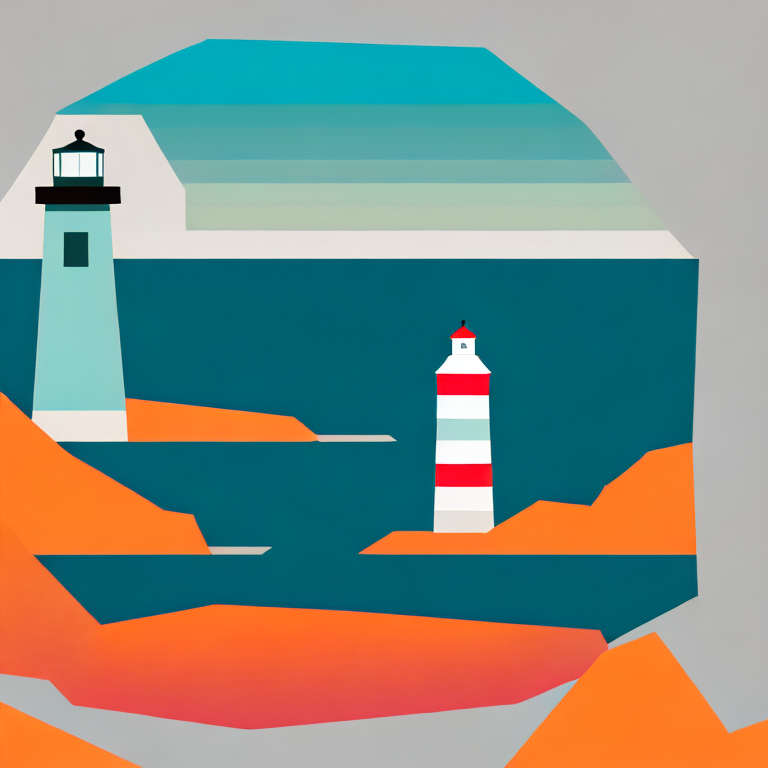

In [13]:
# 作成したプロンプトとネガティブプロンプトを使って画像を生成
# generate_bitmap関数はCFGからデフォルトの推論ステップ数とガイダンススケールを使用
image = generate_bitmap(prompt, negative_prompt=negative_prompt_demo)
image # 生成された画像を表示 (Jupyter環境)

In [14]:
# 生成されたビットマップ画像のスコアを計算
# random_seedはCFGから取得
bitmap_scores = bitmap_score_instance(r.multiple_choice_qa, image, random_seed=CFG.random_seed)
print(f"ビットマップ画像のスコア: {bitmap_scores}")

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


ビットマップ画像のスコア: {'competition_score': 2.186666467904544e-07, 'vqa_score': 0.7460541914578382, 'ocr_score': 3.059023205018258e-07, 'aesthetic_score': 0.4879016876220703}


# 画像 -> SVG
このセクションでは、生成されたビットマップ画像をSVG形式に変換する処理を実装します。
主な処理の流れは以下の通りです：
1. 色の量子化: 画像の色数を減らし、主要な色のみを保持します。
2. 輪郭抽出: 量子化された画像から、各色の領域の輪郭を検出します。
3. 輪郭の単純化: 検出された輪郭をポリゴンで近似し、頂点数を減らしてSVGファイルのサイズを削減します。
4. 特徴の階層化と選択: 輪郭（ポリゴン）を面積や位置などの重要度でソートし、SVGのファイルサイズ制限内でできるだけ多くの情報を含むようにポリゴンを選択・単純化します。
5. SVG生成: 選択されたポリゴンをSVG要素として記述し、SVGファイルを構築します。

In [15]:
#| export

# 16進数カラーコードを短縮表現に変換する関数
# 例: #FF00AA -> #F0A (R,G,Bがそれぞれ17の倍数の場合)
def compress_hex_color(hex_color):
    """16進数のカラーコードを可能な限り短い表現に変換します（例: #aabbcc -> #abc）。"""
    r, g, b = int(hex_color[1:3], 16), int(hex_color[3:5], 16), int(hex_color[5:7], 16)
    if r % 17 == 0 and g % 17 == 0 and b % 17 == 0:
        # 各RGB値が17の倍数の場合、1桁の16進数で表現可能
        return f'#{r//17:x}{g//17:x}{b//17:x}'
    return hex_color

# 画像から階層的な特徴（色ごとのポリゴン）を抽出する関数
def extract_features_by_scale(img_np, num_colors=16): # num_colorsはbitmap_to_svg_layeredから渡される
    """
    画像から色ごとの輪郭を抽出し、重要度に基づいてソートされた特徴のリストを返します。
    Args:
        img_np (np.ndarray): 入力画像 (NumPy配列)。
        num_colors (int): 量子化する色の数。
    Returns:
        list: 抽出されたポリゴンの特徴 (座標、色、面積、重要度など) のリスト。
    """
    # 画像がグレースケールの場合、RGBに変換
    if len(img_np.shape) == 3 and img_np.shape[2] > 1:
        img_rgb = img_np
    else:
        img_rgb = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)

    height, width = img_rgb.shape[:2]

    # k-means法による色の量子化
    pixels = img_rgb.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2) # k-meansの停止条件
    _, labels, centers = cv2.kmeans(pixels, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    palette = centers.astype(np.uint8) # 量子化された色のパレット
    quantized_image = palette[labels.flatten()].reshape(img_rgb.shape) # 量子化された画像

    hierarchical_features = [] # 抽出された特徴を格納するリスト

    # 色の出現頻度に基づいてソート
    unique_labels, counts = np.unique(labels, return_counts=True)
    sorted_indices = np.argsort(-counts) # 降順ソート
    sorted_colors = [palette[i] for i in sorted_indices]

    center_x, center_y = width / 2, height / 2 # 画像中心

    # ソートされた各色について輪郭を抽出
    for color_val in sorted_colors:
        # 特定の色に対応するマスクを作成
        color_mask = cv2.inRange(quantized_image, color_val, color_val)
        
        # マスクから輪郭を検出
        contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=cv2.contourArea, reverse=True) # 面積でソート

        hex_color_str = compress_hex_color(f'#{color_val[0]:02x}{color_val[1]:02x}{color_val[2]:02x}')

        color_specific_features = []
        for contour in contours:
            area = cv2.contourArea(contour)
            # 小さすぎる輪郭は無視 (CFGから閾値を取得)
            if area < CFG.svg_contour_min_area:
                continue

            # 輪郭のモーメントを計算して中心座標を取得
            m = cv2.moments(contour)
            if m["m00"] == 0: continue # 面積0の輪郭はスキップ
            cx = int(m["m10"] / m["m00"])
            cy = int(m["m01"] / m["m00"])

            # 画像中心からの距離 (正規化)
            dist_from_center = np.sqrt(((cx - center_x) / width)**2 + ((cy - center_y) / height)**2)

            # 輪郭を単純化 (Douglas-Peuckerアルゴリズム)
            epsilon = CFG.svg_approx_poly_dp_epsilon_factor * cv2.arcLength(contour, True) # epsilon係数はCFGから取得
            approx_poly = cv2.approxPolyDP(contour, epsilon, True)

            # ポリゴンの頂点座標を文字列に変換 (小数点以下1桁)
            points_str = " ".join([f"{pt[0][0]:.1f},{pt[0][1]:.1f}" for pt in approx_poly])

            # 特徴の重要度を計算 (面積、中心からの近さ、複雑さの逆数)
            importance = (area * (1 - dist_from_center) * (1 / (len(approx_poly) + 1e-6))) # ゼロ除算を避ける

            color_specific_features.append({
                'points': points_str,
                'color': hex_color_str,
                'area': area,
                'importance': importance,
                'point_count': len(approx_poly),
                'original_contour': approx_poly # 適応的単純化のために元の輪郭を保存
            })
        
        # この色に関する特徴を重要度でソート
        color_specific_features.sort(key=lambda x: x['importance'], reverse=True)
        hierarchical_features.extend(color_specific_features)

    # 全ての特徴を重要度で最終ソート
    hierarchical_features.sort(key=lambda x: x['importance'], reverse=True)
    return hierarchical_features

# ポリゴンを単純化する関数
def simplify_polygon(points_str, simplification_level):
    """
    ポリゴンの頂点座標文字列を、指定されたレベルに応じて単純化します。
    Args:
        points_str (str): スペース区切りの "x,y" 形式の頂点座標文字列。
        simplification_level (int): 単純化のレベル (0:変更なし, 1:小数点1桁, 2:整数, 3:頂点削減)。
    Returns:
        str: 単純化された頂点座標文字列。
    """
    if simplification_level == 0:
        return points_str

    points_list = points_str.split()

    if simplification_level == 1: # レベル1: 小数点以下1桁に丸める
        return " ".join([f"{float(p.split(',')[0]):.1f},{float(p.split(',')[1]):.1f}" for p in points_list])
    
    if simplification_level == 2: # レベル2: 整数に丸める
        return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in points_list])

    if simplification_level == 3: # レベル3: 頂点数を減らす（1つおきに点を保持、最低3点は確保）
        if len(points_list) <= 4:
            # 点が4つ以下の場合、整数に丸めるだけ
            return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in points_list])
        else:
            # 約半分の点を保持するが、少なくとも3点は維持する
            step = max(2, len(points_list) // 3) # 3点未満にならないよう調整
            reduced_points = [points_list[i] for i in range(0, len(points_list), step)]
            if len(reduced_points) < 3 and len(points_list) >=3: # 元が3点以上なら最低3点
                 reduced_points = points_list[:3]
            if points_list[-1] not in reduced_points and reduced_points: # 最後の点は必ず含める
                reduced_points.append(points_list[-1])
            return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in reduced_points])
    
    return points_str # 未定義のレベルの場合は変更なし

# ビットマップ画像を階層化された特徴抽出を用いてSVGに変換する関数
def bitmap_to_svg_layered(image, 
                         max_size_bytes=CFG.svg_max_size_bytes, 
                         resize=CFG.svg_resize, 
                         target_size=CFG.svg_target_size,
                         adaptive_fill=CFG.svg_adaptive_fill, 
                         num_colors=CFG.svg_num_colors_default):
    """
    ビットマップ画像をSVG形式に変換します。ファイルサイズ制限内で最適化を行います。
    Args:
        image (PIL.Image): 入力画像。
        max_size_bytes (int): SVGの最大許容バイト数。
        resize (bool): 処理前に画像をリサイズするかどうか。
        target_size (tuple): リサイズする場合のターゲットサイズ (幅, 高さ)。
        adaptive_fill (bool): 利用可能なスペースを適応的に埋めるかどうか。
        num_colors (int, optional): 量子化する色の数。Noneの場合、画像のサイズに基づいて適応的に決定。
    Returns:
        str: SVG形式の文字列。
    """
    # num_colorsが指定されていない場合、画像のピクセル数に基づいて適応的に色数を決定
    if num_colors is None:
        pixel_count = (target_size[0] * target_size[1]) if resize else (image.size[0] * image.size[1])
        
        if pixel_count < CFG.svg_num_colors_small_image_threshold:
            num_colors = CFG.svg_num_colors_for_small_image
        elif pixel_count < CFG.svg_num_colors_medium_image_threshold:
            num_colors = CFG.svg_num_colors_for_medium_image
        else:
            num_colors = CFG.svg_num_colors_for_large_image
    
    original_size = image.size
    if resize:
        image = image.resize(target_size, Image.LANCZOS) # LANCZOSでリサンプル
    
    img_np_array = np.array(image)
    current_height, current_width = img_np_array.shape[:2]

    # 背景色を画像の平均色で決定 (RGB画像の場合)
    if len(img_np_array.shape) == 3 and img_np_array.shape[2] == 3:
        avg_bg_color_val = np.mean(img_np_array, axis=(0,1)).astype(int)
        bg_hex_color_str = compress_hex_color(f'#{avg_bg_color_val[0]:02x}{avg_bg_color_val[1]:02x}{avg_bg_color_val[2]:02x}')
    else: # グレースケール等の場合は白背景
        bg_hex_color_str = '#fff' 

    # SVGヘッダーと背景。viewBoxは処理後の画像の寸法、width/heightは元の画像の寸法
    orig_width, orig_height = original_size
    svg_header_str = f'<svg xmlns="http://www.w3.org/2000/svg" width="{orig_width}" height="{orig_height}" viewBox="0 0 {current_width} {current_height}">\n'
    svg_bg_rect_str = f'<rect width="{current_width}" height="{current_height}" fill="{bg_hex_color_str}"/>\n'
    svg_base_content = svg_header_str + svg_bg_rect_str
    svg_footer_str = '</svg>'

    base_content_size = len((svg_base_content + svg_footer_str).encode('utf-8'))
    available_bytes_for_features = max_size_bytes - base_content_size

    # 画像から特徴（ポリゴン）を抽出
    extracted_features = extract_features_by_scale(img_np_array, num_colors=num_colors)

    # 適応的フィルを使用しない場合: 単純に特徴を追加していく
    if not adaptive_fill:
        current_svg_content = svg_base_content
        for feature_item in extracted_features:
            feature_svg_element = f'<polygon points="{feature_item["points"]}" fill="{feature_item["color"]}" />\n'
            if len((current_svg_content + feature_svg_element + svg_footer_str).encode('utf-8')) > max_size_bytes:
                break # サイズ制限を超えたら終了
            current_svg_content += feature_svg_element
        current_svg_content += svg_footer_str
        return current_svg_content

    # 適応的フィルを使用する場合: 2パスアプローチで単純化レベルを調整しながら特徴を追加
    # 各特徴について、異なる単純化レベルでのSVG要素サイズを事前計算
    feature_element_sizes = []
    for feature_item in extracted_features:
        feature_element_sizes.append({
            'original': len(f'<polygon points="{feature_item["points"]}" fill="{feature_item["color"]}" />\n'.encode('utf-8')),
            'level1': len(f'<polygon points="{simplify_polygon(feature_item["points"], 1)}" fill="{feature_item["color"]}" />\n'.encode('utf-8')),
            'level2': len(f'<polygon points="{simplify_polygon(feature_item["points"], 2)}" fill="{feature_item["color"]}" />\n'.encode('utf-8')),
            'level3': len(f'<polygon points="{simplify_polygon(feature_item["points"], 3)}" fill="{feature_item["color"]}" />\n'.encode('utf-8'))
        })

    current_svg_content = svg_base_content
    bytes_used_so_far = base_content_size
    added_feature_indices = set()

    # パス1: 最も重要な特徴を元の品質で追加
    for i, feature_item in enumerate(extracted_features):
        feature_svg_element = f'<polygon points="{feature_item["points"]}" fill="{feature_item["color"]}" />\n'
        current_feature_size = feature_element_sizes[i]['original']
        if bytes_used_so_far + current_feature_size <= max_size_bytes:
            current_svg_content += feature_svg_element
            bytes_used_so_far += current_feature_size
            added_feature_indices.add(i)

    # パス2: 残りの特徴を単純化レベルを上げながら追加
    for simpl_level in range(1, 4): # 単純化レベル 1, 2, 3
        for i, feature_item in enumerate(extracted_features):
            if i in added_feature_indices: continue # 既に追加済みならスキップ

            current_feature_size = feature_element_sizes[i][f'level{simpl_level}']
            if bytes_used_so_far + current_feature_size <= max_size_bytes:
                simplified_points = simplify_polygon(feature_item["points"], simpl_level)
                feature_svg_element = f'<polygon points="{simplified_points}" fill="{feature_item["color"]}" />\n'
                current_svg_content += feature_svg_element
                bytes_used_so_far += current_feature_size
                added_feature_indices.add(i)
    
    current_svg_content += svg_footer_str

    # 最終的なサイズチェック。万が一超過していたら、背景のみのSVGを返す
    final_svg_size = len(current_svg_content.encode('utf-8'))
    if final_svg_size > max_size_bytes:
        return f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 {current_width} {current_height}"><rect width="{current_width}" height="{current_height}" fill="{bg_hex_color_str}"/></svg>'
    
    # print(f"SVG size: {final_svg_size} bytes, Utilization: {(final_svg_size / max_size_bytes) * 100:.2f}%")
    return current_svg_content

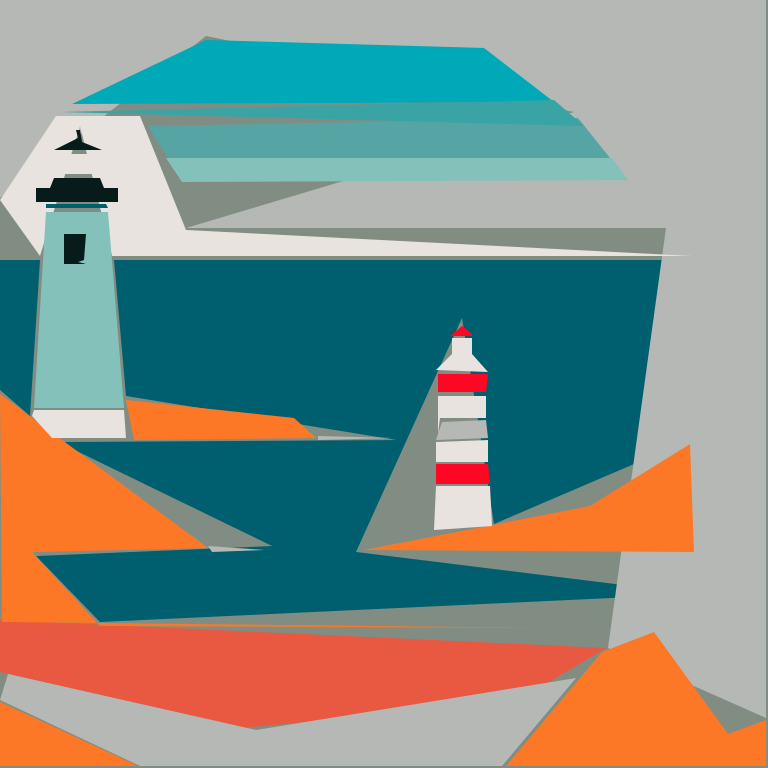

In [16]:
# 先ほど生成したビットマップ画像をSVGに変換
# bitmap_to_svg_layered関数はCFGからデフォルト引数を使用
svg_content = bitmap_to_svg_layered(image)
SVG(svg_content) # 生成されたSVGを表示 (Jupyter環境)

In [17]:
# 生成されたSVGのスコアを計算
# random_seedはCFGから取得
svg_scores = metric.score_instance(r.multiple_choice_qa, svg_content, random_seed=CFG.random_seed)
print(f"SVG画像のスコア: {svg_scores}")

SVG画像のスコア: {'competition_score': 0.7963788369236056, 'vqa_score': 0.9187117491304084, 'ocr_score': 1.0, 'aesthetic_score': 0.5196165084838867}


In [18]:
#| export
# SVGコンテンツから美的スコアとOCRスコアを取得する関数
def get_aes_and_ocr_score(svg_content_str):
    """
    SVG文字列から美的スコアとOCRスコアを計算します。
    Args:
        svg_content_str (str): SVG形式の文字列。
    Returns:
        tuple: (美的スコア, OCRスコア)。
    """
    # SVGをPNGに変換し、画像処理を実行 (シードはCFGから取得)
    image_proc = metric.ImageProcessor(image=metric.svg_to_png(svg_content_str), seed=CFG.aes_ocr_seed).apply()
    processed_img = image_proc.image.copy()
    
    aesthetic_val = metric.aesthetic_evaluator.score(processed_img) # 美的スコア計算
    
    # OCRスコア計算用の画像処理 (ランダムクロップ・リサイズ、JPEG圧縮。品質はCFGから取得)
    image_proc.reset().apply_random_crop_resize().apply_jpeg_compression(quality=CFG.aes_ocr_jpeg_quality)
    ocr_val = metric.vqa_evaluator.ocr(image_proc.image) # OCRスコア計算
    
    return aesthetic_val, ocr_val

In [19]:
# 先ほど生成したSVGの美的スコアとOCRスコアを取得
aesthetic_score_val, ocr_score_val = get_aes_and_ocr_score(svg_content)
print(f"美的スコア: {aesthetic_score_val}, OCRスコア: {ocr_score_val}")

美的スコア: 0.526546859741211, OCRスコア: 0.36787944117144233


## パッケージのModelクラスを実装
この`Model`クラスは、画像生成からSVG変換、そしてスコアベースの最適化までの一連の処理をカプセル化します。
`predict`メソッドは、与えられた説明文から最適なSVGを生成することを目指します。
内部では複数回画像を生成し、美的スコアとOCRスコアの積が最大となるものを選択します。

In [20]:
#| export

class Model:
    def __init__(self):
        # CFGからモデルのデフォルト設定を初期化
        self.default_svg = CFG.model_default_svg
        self.prompt_prefix = CFG.model_prompt_prefix
        self.prompt_suffix = CFG.model_prompt_suffix
        self.negative_prompt = CFG.model_negative_prompt

        self.num_inference_steps = CFG.model_num_inference_steps # 画像生成時の推論ステップ数
        self.guidance_scale = CFG.model_guidance_scale           # 画像生成時のガイダンススケール
        self.num_attempt = CFG.model_num_attempt                 # 最適なSVGを見つけるための試行回数

    # 説明文に基づいてビットマップ画像を生成する内部メソッド
    def gen_bitmap(self, description_text):
        # クラス固有のプロンプト接頭辞・接尾辞を使用
        full_prompt = f'{self.prompt_prefix} {description_text} {self.prompt_suffix}'
        # クラス固有の推論ステップ数とガイダンススケールでビットマップを生成
        bitmap_image = generate_bitmap(full_prompt, self.negative_prompt, 
                                      self.num_inference_steps, self.guidance_scale)
        return bitmap_image

    # プロンプト（説明文）からSVGを生成する内部実装メソッド
    # 複数回試行し、美的スコアとOCRスコアの積が最も高いものを選択
    def predict_impl(self, description_prompt: str) -> tuple[str, Image.Image | None]:
        """
        説明文プロンプトから最適なSVG文字列と対応するビットマップ画像を生成します。
        Args:
            description_prompt (str): 画像の内容を表す説明文。
        Returns:
            tuple: (最適なSVG文字列, 対応するビットマップ画像)
        """
        best_combined_score = 0.0
        best_svg_output = None
        best_generated_image = None
        
        for _ in range(self.num_attempt): # 設定された試行回数だけ繰り返す
            # 1. ビットマップ画像を生成
            current_bitmap = self.gen_bitmap(description_prompt)
            
            # 2. ビットマップをSVGに変換 (bitmap_to_svg_layeredはCFG由来のデフォルトパラメータを使用)
            current_svg = bitmap_to_svg_layered(current_bitmap)
            
            # 3. SVGの美的スコアとOCRスコアを取得 (get_aes_and_ocr_scoreはCFG由来のデフォルトパラメータを使用)
            aes_score, ocr_s = get_aes_and_ocr_score(current_svg)
            
            # 4. スコアを評価 (美的スコア * OCRスコア)
            current_score = aes_score * ocr_s
            
            if current_score >= best_combined_score: # より良いスコアなら更新
                best_combined_score = current_score
                best_svg_output = current_svg
                best_generated_image = current_bitmap
                print(f'スコア更新: {best_combined_score:.4f} (AES: {aes_score:.4f}, OCR: {ocr_s:.4f})')

        if best_svg_output is None: # 一度も有効なSVGが生成されなかった場合
            best_svg_output = self.default_svg # デフォルトSVGを返す
            best_generated_image = None # この場合、対応するビットマップはない

        return best_svg_output, best_generated_image

    # プロンプト（説明文）からSVGを生成する公開メソッド
    def predict(self, description_prompt: str) -> str:
        """
        説明文プロンプトから最適なSVG文字列を生成します。
        Args:
            description_prompt (str): 画像の内容を表す説明文。
        Returns:
            str: 最適なSVG文字列。
        """
        svg_result, _ = self.predict_impl(description_prompt) # ビットマップは返さない
        return svg_result

In [21]:
# Modelクラスのインスタンスを作成
model = Model()

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4970 (AES: 0.4970, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.5174 (AES: 0.5174, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

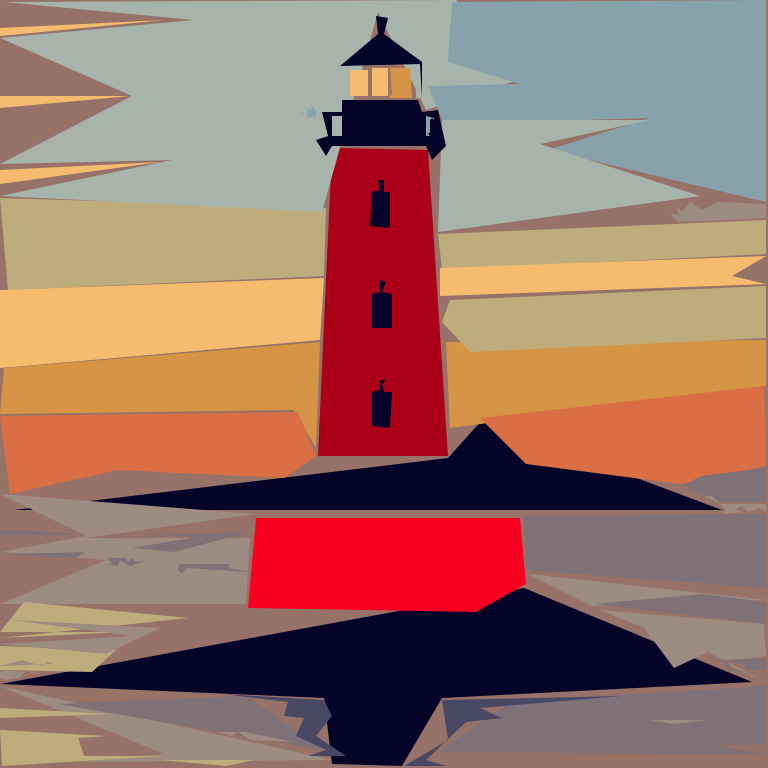

In [22]:
# Modelクラスのpredictメソッドを使用してSVGを生成
# `description`変数は以前のセルで定義されたものを使用
svg_output_from_model = model.predict(description)
SVG(svg_output_from_model) # 生成されたSVGを表示

In [23]:
# Modelクラスによって生成されたSVGのスコアを計算
# `r`変数は以前のセルで定義されたサンプルデータ
# random_seedはCFGから取得
model_svg_scores = metric.score_instance(r.multiple_choice_qa, svg_output_from_model, random_seed=CFG.random_seed)
print(f"Model生成SVGのスコア: {model_svg_scores}")

Model生成SVGのスコア: {'competition_score': 0.6892329505525903, 'vqa_score': 0.7490838032187233, 'ocr_score': 1.0, 'aesthetic_score': 0.5223064422607422}


## 学習データセットで評価（LB予測）
学習データセット全体に対してモデルを適用し、生成されたSVGの平均スコアを計算します。
これにより、リーダーボード（LB）でのスコアをある程度予測することができます。
各サンプルについて、元のビットマップ画像のスコアと、生成されたSVGのスコアの両方を評価し比較します。

In [24]:
import matplotlib.pyplot as plt # matplotlibは既にインポート済みだが、セル単位の自己完結性のため記述
%matplotlib inline
# Jupyter Notebookでmatplotlibのプロットをインライン表示するためのマジックコマンド

In [25]:
import pandas as pd # pandasは既にインポート済みだが、セル単位の自己完結性のため記述
from tqdm.auto import tqdm # tqdm (プログレスバー表示用) は既にインポート済みだが、セル単位の自己完結性のため記述
tqdm.pandas() # pandasのapply操作でプログレスバーを表示できるようにする

In [26]:
# 学習データフレームの先頭を表示して再確認
train_df.head()

id                                        description  \
0  02d892                            a purple forest at dusk   
1  0dcd2e              gray wool coat with a faux fur collar   
2  1e9ac1                 a lighthouse overlooking the ocean   
3  2b25db  burgundy corduroy pants with patch pockets and...   
4  4e6a54                           orange corduroy overalls   

                                                  qa  \
0  {'id': ['02d892', '02d892', '02d892', '02d892'...   
1  {'id': ['0dcd2e', '0dcd2e', '0dcd2e', '0dcd2e'...   
2  {'id': ['1e9ac1', '1e9ac1', '1e9ac1', '1e9ac1'...   
3  {'id': ['2b25db', '2b25db', '2b25db', '2b25db'...   
4  {'id': ['4e6a54', '4e6a54', '4e6a54', '4e6a54'...   

                                            question  \
0  ["What is the main setting of the image?", "Is...   
1  ["What color is the coat?", "What part of the ...   
2  ["Is there an ocean visible in the image?", "W...   
3  ["Are the pants yellow?", "Do the pants have p...   
4  ["What material is the item?", "Is a hat depic...   

                                             choices  \
0  [["beach", "desert", "forest", "mountain"], ["...   
1  [["blue", "brown", "gray", "red"], ["collar", ...   
2  [["no", "yes"], ["inside", "next to", "overloo...   
3  [["no", "yes"], ["no", "yes"], ["no", "yes"], ...   
4  [["corduroy", "denim", "leather", "silk"], ["n...   

                                  answer  \
0    ["forest", "yes", "dusk", "purple"]   
1       ["gray", "collar", "no", "wool"]   
2     ["yes", "overlooking", "no", "no"]   
3          ["no", "yes", "yes", "pants"]   
4  ["corduroy", "no", "yes", "overalls"]   

                                  multiple_choice_qa  
0  {'question': ['What is the main setting of the...  
1  {'question': ['What color is the coat?', 'What...  
2  {'question': ['Is there an ocean visible in th...  
3  {'question': ['Are the pants yellow?', 'Do the...  
4  {'question': ['What material is the item?', 'I...

In [27]:
# 学習データセットの各説明文に対してmodel.predict_implを実行し、結果 (SVGとビットマップ) を保存
# progress_applyで処理の進捗を表示
train_df['raw_res'] = train_df.description.progress_apply(model.predict_impl)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.5129 (AES: 0.5129, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4902 (AES: 0.4902, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4997 (AES: 0.4997, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.5113 (AES: 0.5113, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4754 (AES: 0.4754, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4807 (AES: 0.4807, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.0000 (AES: 0.4253, OCR: 0.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4362 (AES: 0.4362, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4540 (AES: 0.4540, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4617 (AES: 0.4617, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4813 (AES: 0.4813, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4277 (AES: 0.4277, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4546 (AES: 0.4546, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.0004 (AES: 0.4840, OCR: 0.0009)


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.5111 (AES: 0.5111, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4568 (AES: 0.4568, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4292 (AES: 0.4292, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4865 (AES: 0.4865, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4883 (AES: 0.4883, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4942 (AES: 0.4942, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.5380 (AES: 0.5380, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.5415 (AES: 0.5415, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4309 (AES: 0.4309, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4312 (AES: 0.4312, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4381 (AES: 0.4381, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4946 (AES: 0.4946, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

In [28]:
# 'raw_res' カラムからSVG文字列とビットマップ画像をそれぞれ別のカラムに展開
train_df['svg'] = train_df.raw_res.apply(lambda x: x[0])
train_df['bitmap'] = train_df.raw_res.apply(lambda x: x[1])

In [29]:
# 各ビットマップ画像のスコアを計算
# progress_applyで処理の進捗を表示
# random_seedはCFGから取得
train_df['bitmap_score'] = train_df.progress_apply(
    lambda r: bitmap_score_instance(r.multiple_choice_qa, r.bitmap, random_seed=CFG.random_seed) if r.bitmap else None, # ビットマップが存在しない場合はNone
    axis=1,
)

  0%|          | 0/15 [00:00<?, ?it/s]

In [30]:
# 各SVG画像のスコアを計算
# progress_applyで処理の進捗を表示
# random_seedはCFGから取得
train_df['svg_score'] = train_df.progress_apply(
    lambda r: metric.score_instance(r.multiple_choice_qa, r.svg, random_seed=CFG.random_seed),
    axis=1,
)

  0%|          | 0/15 [00:00<?, ?it/s]

<ipython-input-31-9681d3cd486e>:40: UserWarning: Glyph 12499 (\N{KATAKANA LETTER BI}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.9]) # suptitleとの重なりを避ける
<ipython-input-31-9681d3cd486e>:40: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.9]) # suptitleとの重なりを避ける
<ipython-input-31-9681d3cd486e>:40: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.9]) # suptitleとの重なりを避ける
<ipython-input-31-9681d3cd486e>:40: UserWarning: Glyph 12510 (\N{KATAKANA LETTER MA}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.9]) # suptitleとの重なりを避ける
<ipython-input-31-9681d3cd486e>:40: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.9]) # suptitleとの重なりを避ける
<ipython-input-31-9681d3cd486e>:40: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  plt.tight_layo

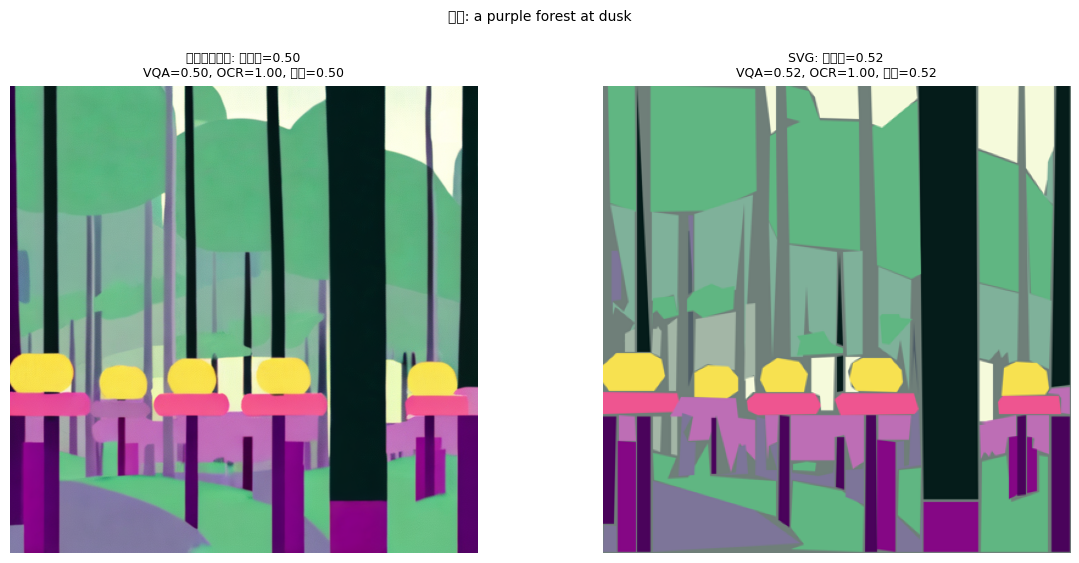

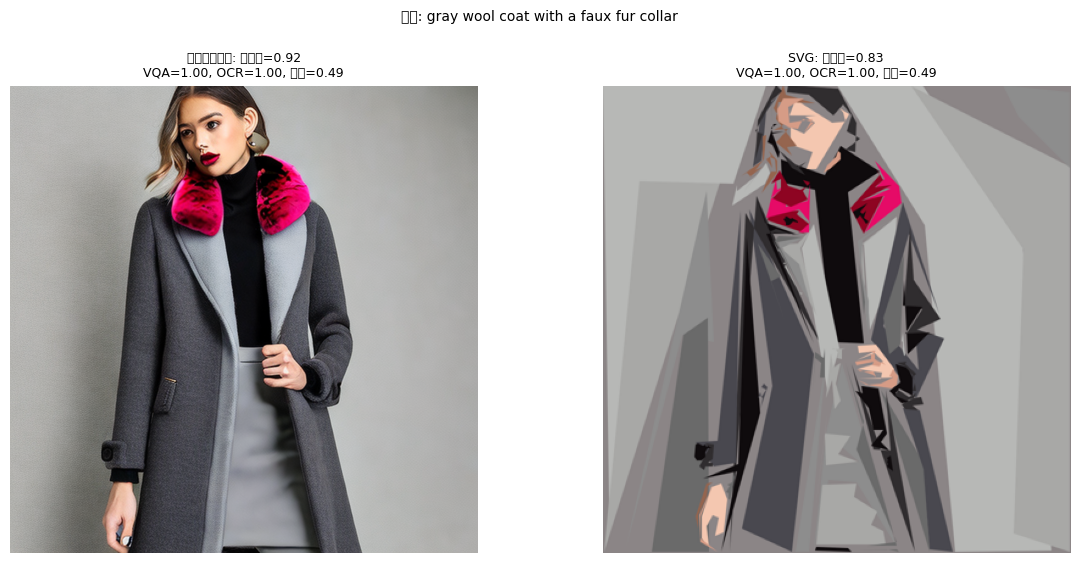

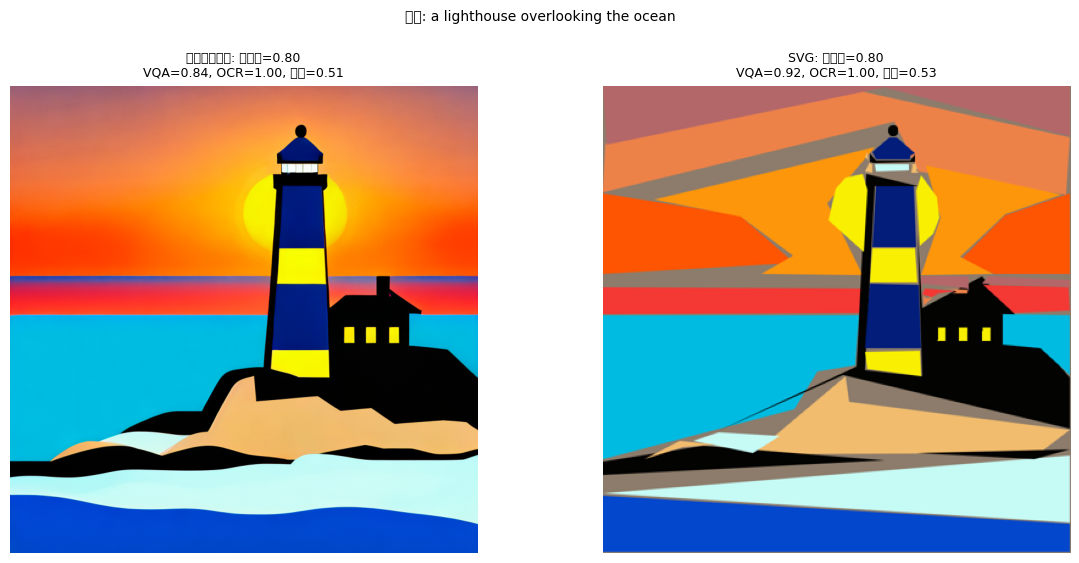

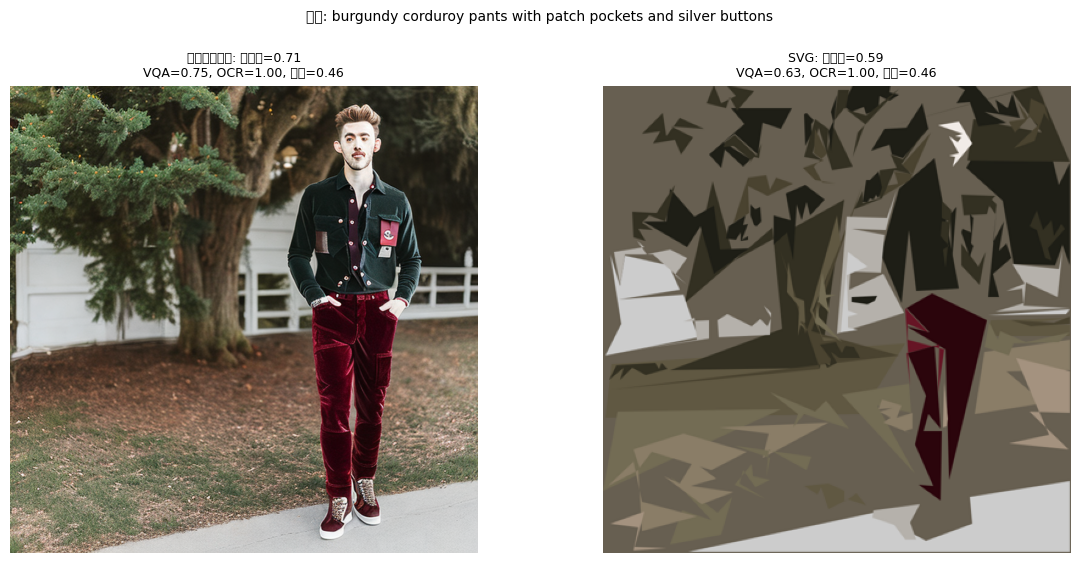

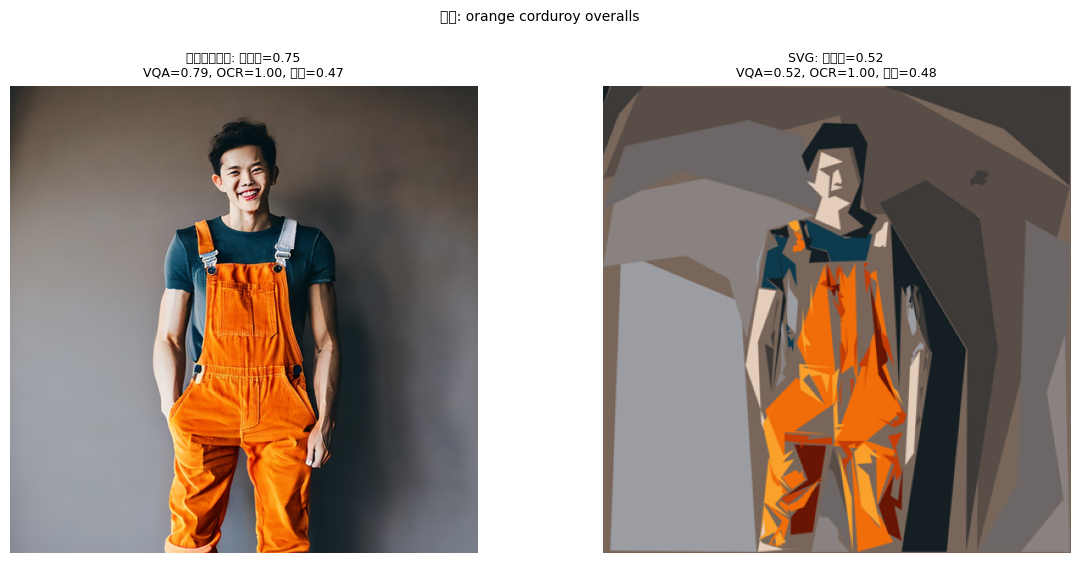

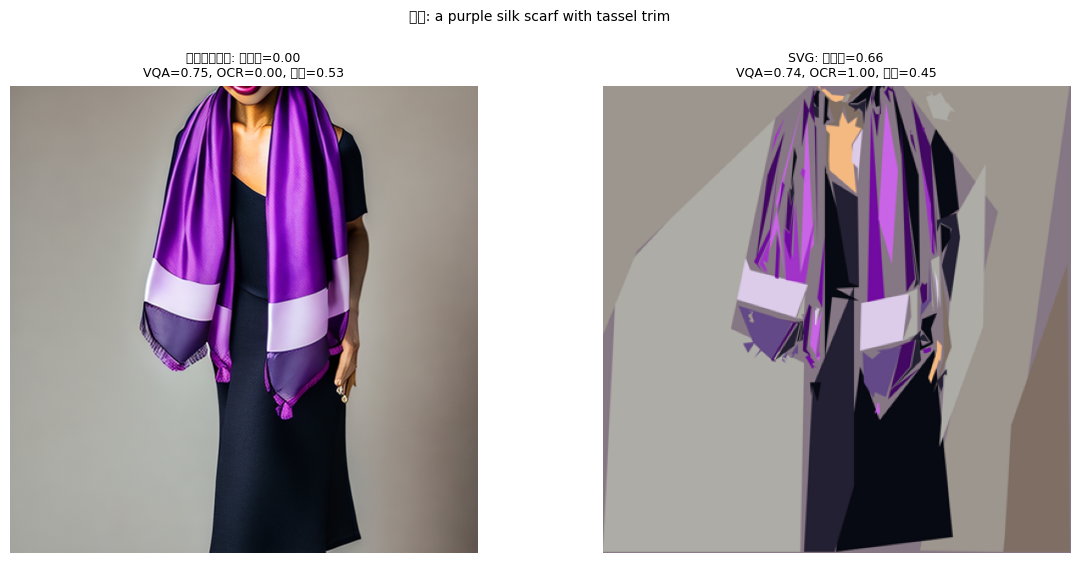

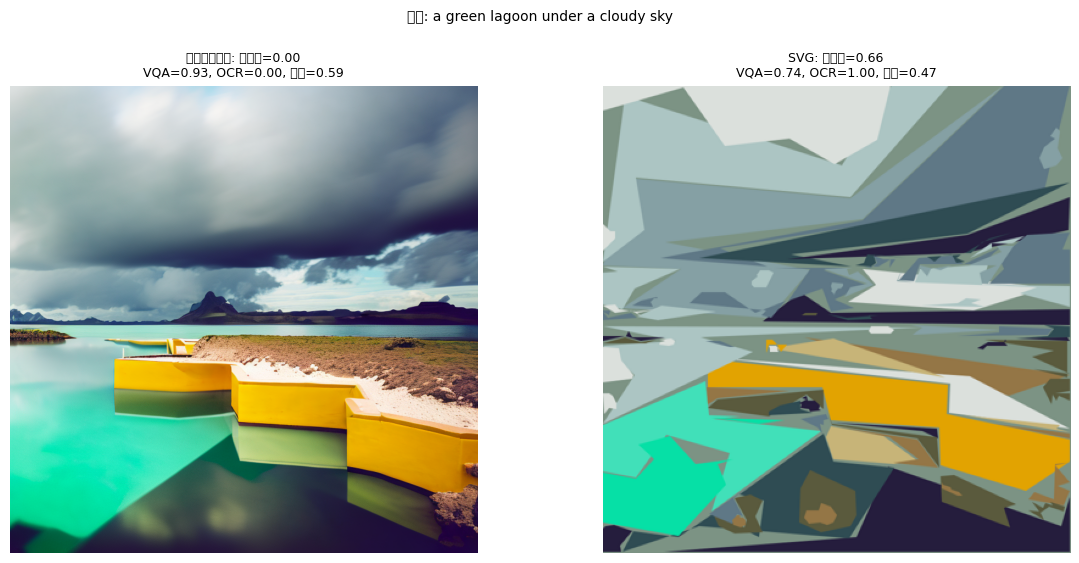

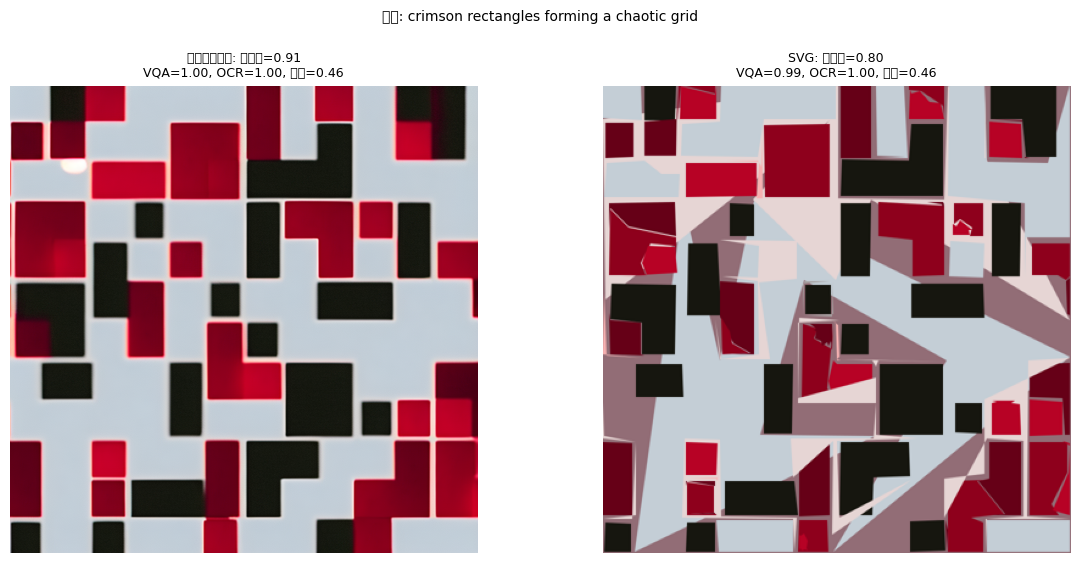

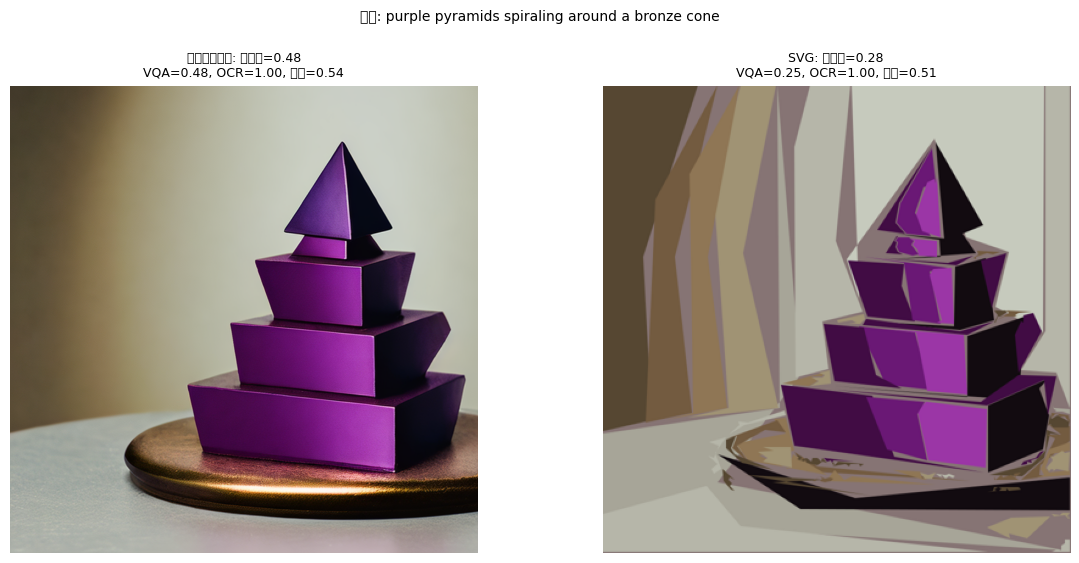

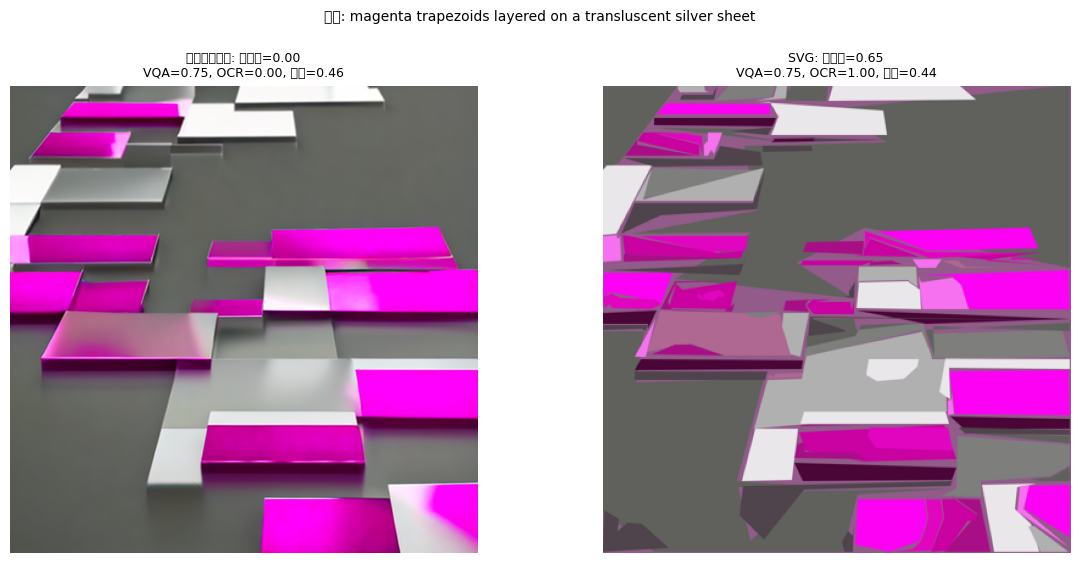

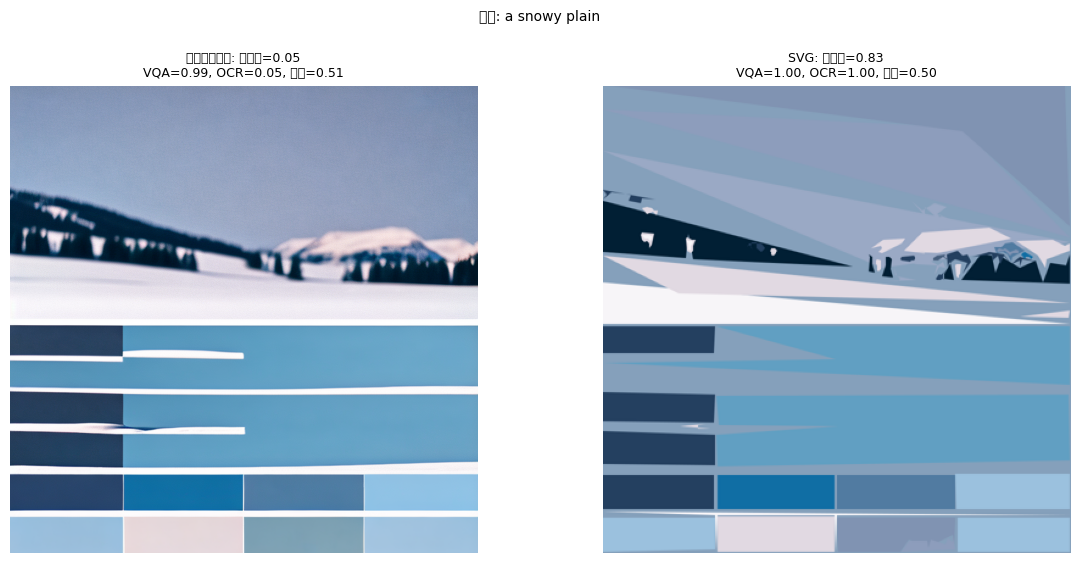

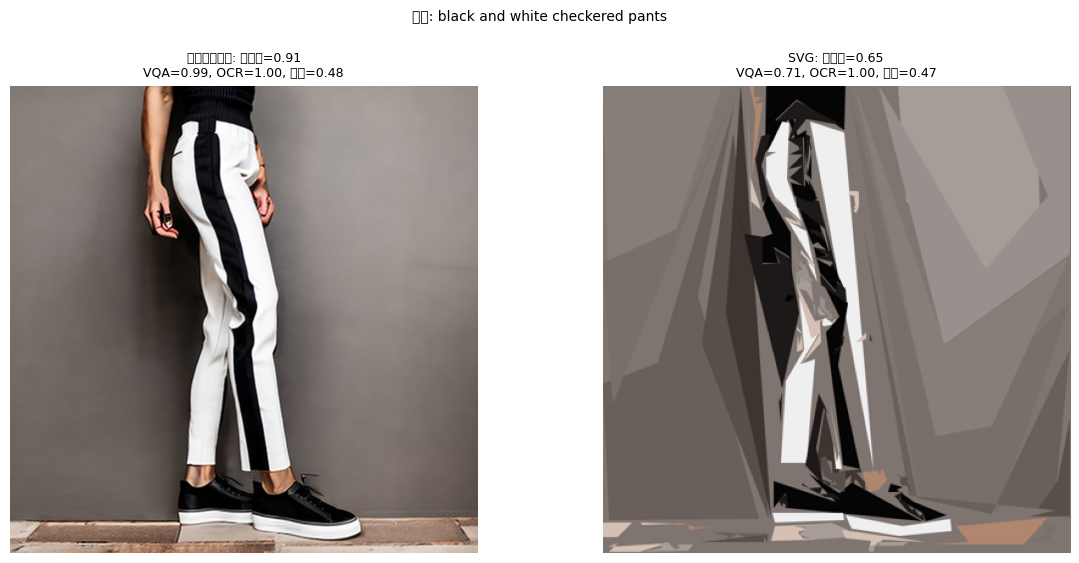

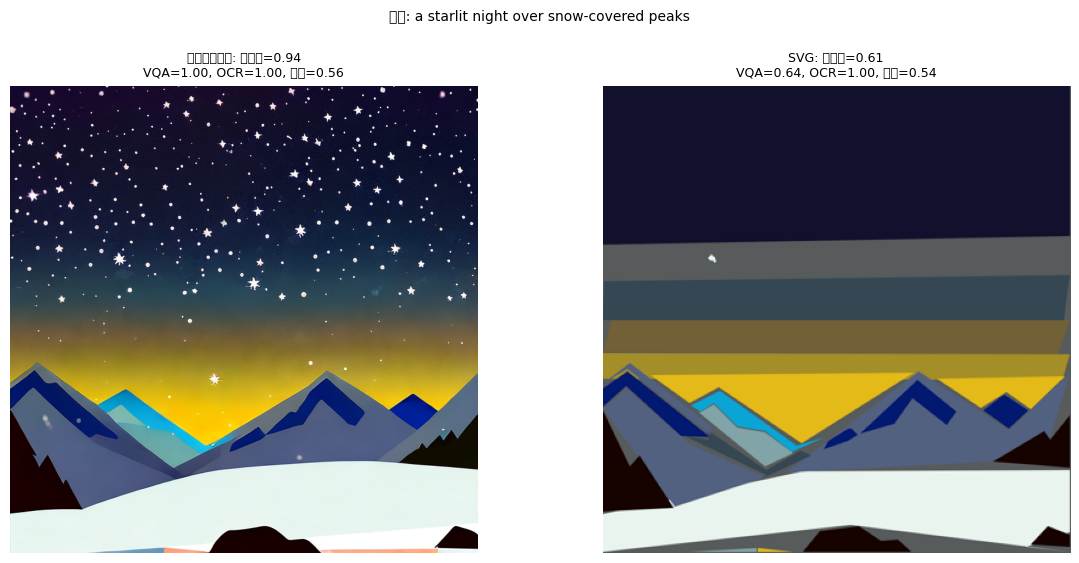

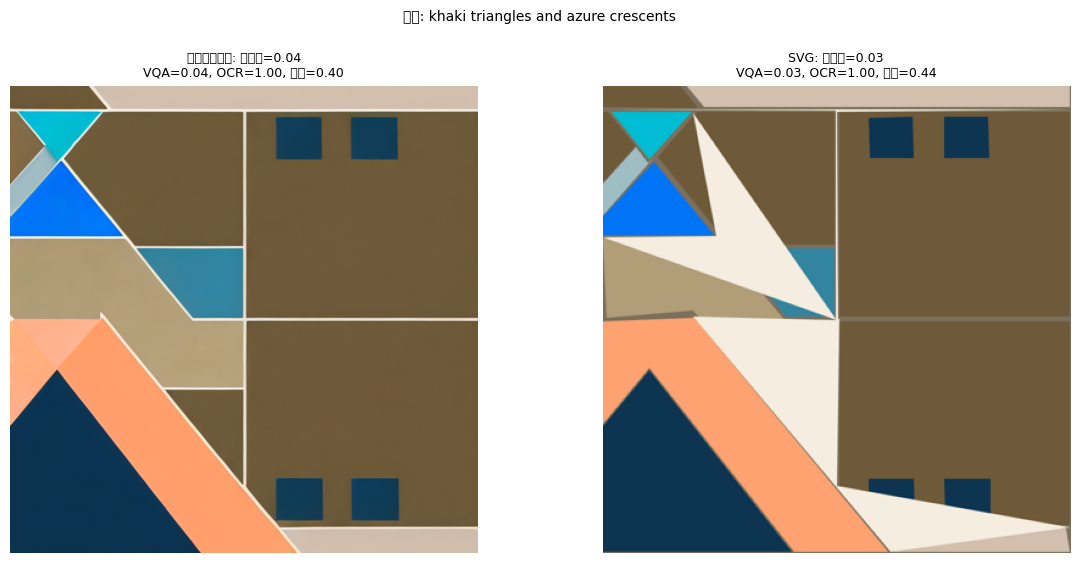

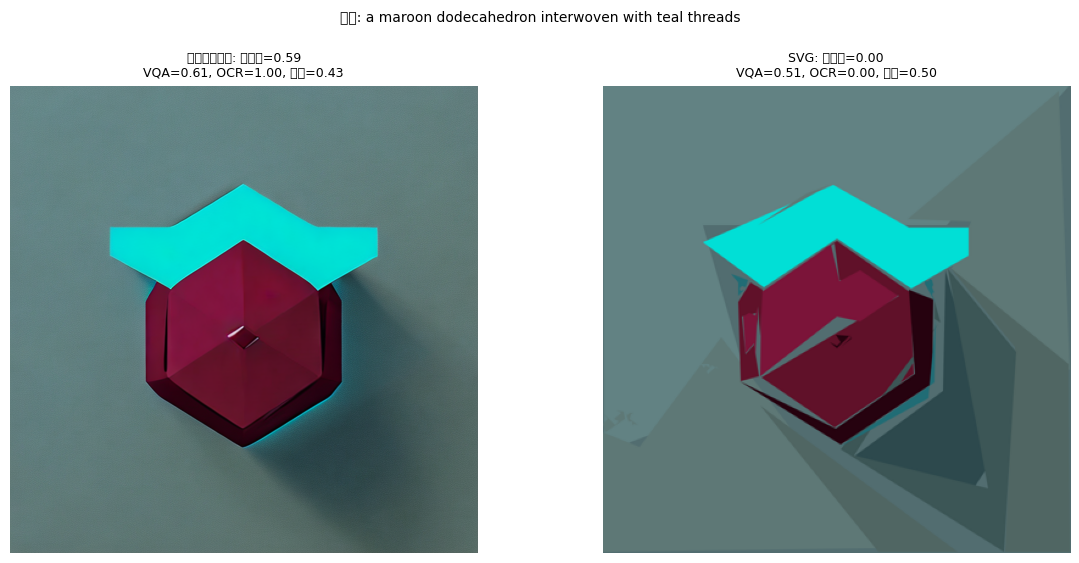

In [31]:
# 学習データセットの各サンプルについて、ビットマップ画像とSVG画像を並べて表示し、それぞれのスコアを表示
for r in train_df.itertuples():
    # ビットマップのスコア詳細を取得 (存在する場合のみ)
    if r.bitmap and r.bitmap_score:
        b_score = r.bitmap_score.get('competition_score', 0)
        b_vqa = r.bitmap_score.get('vqa_score', 0)
        b_ocr = r.bitmap_score.get('ocr_score', 0)
        b_aesthetic = r.bitmap_score.get('aesthetic_score', 0)
    else: # ビットマップやスコアが存在しない場合
        b_score, b_vqa, b_ocr, b_aesthetic = 0, 0, 0, 0

    # SVGのスコア詳細を取得
    s_score = r.svg_score.get('competition_score', 0)
    s_vqa = r.svg_score.get('vqa_score', 0)
    s_ocr = r.svg_score.get('ocr_score', 0)
    s_aesthetic = r.svg_score.get('aesthetic_score', 0)

    plt.figure(figsize=(12, 6))
    plt.suptitle(f"説明: {r.description}", y=0.93, fontsize=10) # yとfontsize調整

    # ビットマップ画像表示
    plt.subplot(1, 2, 1)
    if r.bitmap:
        plt.imshow(np.array(r.bitmap))
    else: # ビットマップがない場合はテキスト表示
        plt.text(0.5, 0.5, "No Bitmap Generated", ha='center', va='center')
    plt.axis('off')
    plt.title(f'ビットマップ: スコア={b_score:.2f}\nVQA={b_vqa:.2f}, OCR={b_ocr:.2f}, 美的={b_aesthetic:.2f}', fontsize=9)

    # SVG画像表示 (PNGに変換して表示)
    plt.subplot(1, 2, 2)
    try:
        plt.imshow(metric.svg_to_png(r.svg))
    except Exception as e: # SVG変換エラーの場合
        plt.text(0.5, 0.5, f"SVG Display Error:\n{e}", ha='center', va='center', fontsize=8)

    plt.axis('off')
    plt.title(f'SVG: スコア={s_score:.2f}\nVQA={s_vqa:.2f}, OCR={s_ocr:.2f}, 美的={s_aesthetic:.2f}', fontsize=9)
    
    plt.tight_layout(rect=[0, 0, 1, 0.9]) # suptitleとの重なりを避ける
    plt.show()

In [32]:
# ビットマップスコアの平均を計算して表示 (Noneを除外)
valid_bitmap_scores = [s for s in train_df['bitmap_score'].tolist() if s is not None]
if valid_bitmap_scores:
    mean_bitmap_score = pd.DataFrame(valid_bitmap_scores).mean(axis=0)
    print("平均ビットマップスコア:")
    print(mean_bitmap_score)
else:
    print("有効なビットマップスコアがありません。")

平均ビットマップスコア:
competition_score    0.507176
vqa_score            0.761421
ocr_score            0.736656
aesthetic_score      0.492666
dtype: float64


In [33]:
# SVGスコアの平均を計算して表示 (Noneを除外)
valid_svg_scores = [s for s in train_df['svg_score'].tolist() if s is not None]
if valid_svg_scores:
    mean_svg_score = pd.DataFrame(valid_svg_scores).mean(axis=0)
    print("平均SVGスコア:")
    print(mean_svg_score)
else:
    print("有効なSVGスコアがありません。")

平均SVGスコア:
competition_score    0.562125
vqa_score            0.662923
ocr_score            0.933342
aesthetic_score      0.484309
dtype: float64


In [34]:
# 最終的な平均コンペティションスコアを表示
if valid_bitmap_scores:
    print(f'元のビットマップ画像の平均コンペティションスコア: {mean_bitmap_score.competition_score if "competition_score" in mean_bitmap_score else "N/A"}')
if valid_svg_scores:
    print(f'最終的なSVG画像の平均コンペティションスコア: {mean_svg_score.competition_score if "competition_score" in mean_svg_score else "N/A"}')

元のビットマップ画像の平均コンペティションスコア: 0.5071764432364806
最終的なSVG画像の平均コンペティションスコア: 0.5621245383779833
